In [ ]:
!pip install torch torchvision torchtune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
import math
import torch
from torch import nn
from torchvision.models import densenet121, DenseNet121_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torchtune.modules import RotaryPositionalEmbeddings
from torchvision import tv_tensors
from torchvision.transforms import v2

In [ ]:
max_video_length = 24
num_features = 1024
image_size = 128

## Download data

To limit the runtime of this notebook, a subsampled version (Paul, 2021) of the UCF101 dataset is used that contains only the 5 most frequent classes. It is already split into train and test data.

In [ ]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz
train_df = pd.read_csv("train.csv")
labels = list(train_df['tag'].value_counts().index)

As we can see, the train data are almost perfectly balanced:

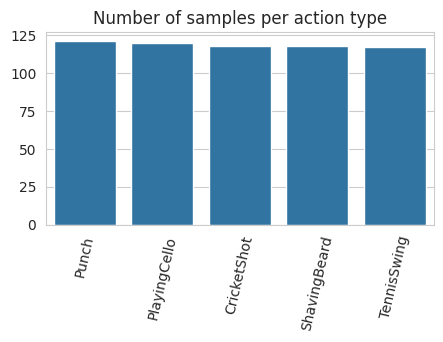

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(5, 2.5))
p = sns.countplot(
    train_df,
    x='tag',
    order = train_df['tag'].value_counts().index,
    ax=ax
)
p.set_xlabel(None)
p.set_ylabel(None)
p.set_xticks(range(5))
p.set_xticklabels(labels=labels, rotation=77)
p.set_title("Number of samples per action type")
plt.show()

## Define feature extractor

A pre-trained image classification model will be used to extract features from the video frames


In [ ]:
class FeatureExtractor():

    def __init__(
        self,
        model,
        weights
    ):
        model = model(weights = weights)
        model.eval()
        self.model = model
        self.preprocessing = weights.transforms()
        nodes, _ = get_graph_node_names(self.model)
        self.nodes = nodes

    def extract(
        self,
        layer_idx,
        model_input
    ):
        return_node_name = self.nodes[layer_idx]
        return_nodes = {return_node_name: return_node_name}
        extractor = create_feature_extractor(
            self.model,
            return_nodes=return_nodes
        )
        preprocessed_input = self.preprocessing(model_input)
        features = extractor(preprocessed_input)
        node_features = features[return_node_name]

        return node_features.clone().detach()

## Helper functions for data preparation and augmentation

In [ ]:
# The following method was taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    '''
    crop captured frame such that
    resulting image has square shape
    '''
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=24, img_size=(128, 128)):
    video_frames = []
    cap = cv.VideoCapture(path)
    try:
        while True:
            x, frame = cap.read()
            if not x:
                break
            frame = crop_center_square(frame)
            frame = cv.resize(frame, img_size)
            #swap color channels
            frame = frame[:, :, [2, 1, 0]]
            video_frames.append(frame)

            if len(video_frames) == max_frames:
                break
    finally:
        cap.release()

    na = np.array(video_frames)
    tt = torch.tensor(na)/255.
    tt = tt.permute(0, 3, 1, 2)

    return tt

In [ ]:
def encode_labels(df):
    unique_labels = list(df['tag'].unique())
    label_lookup = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = torch.tensor(np.array(list(map(lambda l: label_lookup[l],
                                                    df['tag']))))

    return encoded_labels

def extract_and_pad(video_frames, fx, transform=None):
    if transform is not None:
        video_frames = transform(video_frames)

    video_features = fx.extract(-2, video_frames)

    #add padding where necessary
    if video_features.shape[0] < max_video_length:
        diff = max_video_length - video_features.shape[0]
        padding = torch.zeros((diff, num_features))
        video_features = torch.cat((video_features, padding))

    video_features = video_features.unsqueeze(0)

    return video_features

def prepare_train_samples(df, root_dir, fx, transform=None):
    labels = encode_labels(df)
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    all_frame_features1 = torch.zeros(
        (num_samples, max_video_length, num_features)
    )

    all_frame_features2 = torch.zeros(
        (num_samples, max_video_length, num_features)
    )

    for idx, path in enumerate(video_paths):

        frames = load_video(os.path.join(root_dir, path),
                            img_size=(image_size, image_size))

        video_features_org = extract_and_pad(frames, fx)
        all_frame_features1[idx,] = video_features_org

        video_features_trans = extract_and_pad(frames, fx, transform=transform)
        all_frame_features2[idx,] = video_features_trans

    upsampled_data = torch.cat((all_frame_features1, all_frame_features2))
    upsampled_labels = torch.cat((labels, labels))

    return upsampled_data, upsampled_labels

def prepare_test_samples(df, root_dir, fx):
    labels = encode_labels(df)
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    all_frame_features = torch.zeros(
        (num_samples, max_video_length, num_features)
    )

    for idx, path in enumerate(video_paths):

        frames = load_video(os.path.join(root_dir, path),
                            img_size=(image_size, image_size))

        video_features = extract_and_pad(frames, fx)
        all_frame_features[idx,] = video_features

    return all_frame_features, labels

## Build custom datasets for training and validation

The following steps are performed for all samples:

1. label encoding

2. capture of up to 24 frames of the video

3. extraction of frame features using the DenseNet121 model

4. padding where video length < 24 frames

Furthermore, data augmentation is performed by producing a grayscale copy of each training sample, doubling the size of the training dataset.

In [ ]:
class SubsampledActionDataset(Dataset):
    def __init__(self, dataset_type, fx, transform=None):

        self.transform = transform

        if dataset_type == "test":
            df = pd.read_csv("test.csv")
            self.data, self.labels = prepare_test_samples(
                df,
                dataset_type,
                fx
            )
        else:
            df = pd.read_csv("train.csv")
            self.data, self.labels = prepare_train_samples(
                df,
                dataset_type,
                fx,
                transform=self.transform,
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        vid_features = self.data[idx]
        vid_label = self.labels[idx]

        sample = {'video': vid_features, 'action': vid_label}

        return sample

In [ ]:
#!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
#!tar xf ucf101_top5.tar.gz

net_fx = FeatureExtractor(densenet121, DenseNet121_Weights.IMAGENET1K_V1)

action_dataset_train = SubsampledActionDataset(
    "train",
    net_fx,
    transform=v2.Grayscale(num_output_channels=3)
)

action_dataset_val = SubsampledActionDataset(
    "test",
    net_fx
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 105MB/s]


In [ ]:
torch.save(action_dataset_train, '/content/drive/My Drive/video_train.pt')
torch.save(action_dataset_val, '/content/drive/My Drive/video_val.pt')

In [ ]:
action_dataset_train = torch.load('/content/drive/My Drive/video_train.pt', weights_only=False)
action_dataset_val = torch.load('/content/drive/My Drive/video_val.pt', weights_only=False)
train_dataloader = DataLoader(action_dataset_train, batch_size=16, shuffle=True)
val_dataloader = DataLoader(action_dataset_val, batch_size=16, shuffle=True)

# Build video classifier with TransformerEncoder module and RoPE

The features extracted from the video frames are fed into a TransformerEncoder module with Rotary Positional Embeddings. Global average pooling is performed on the encoder outputs before predictions are generated by the linear output layer.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

        #Rotary Positional Embeddings
        self.rotary_pos_emb = RotaryPositionalEmbeddings(self.d_k)

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def apply_rotation(self, v):
        rotary_pos_emb = self.rotary_pos_emb(v)
        return rotary_pos_emb

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)

        return output

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, x, mask=None):
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))

        #Encode positions
        Q = self.apply_rotation(Q)
        K = self.apply_rotation(K)

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(TransformerEncoder, self).__init__()
        self.device = torch.accelerator.current_accelerator().type \
                      if torch.accelerator.is_available() else "cpu"
        self.num_heads = num_heads
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def generate_padding_mask(self, x):
        padding_mask = (x[:, :, 0] == 0).unsqueeze(1).unsqueeze(2)
        padding_mask = padding_mask.to(self.device)
        return padding_mask

    def forward(self, x):
        padding_mask = self.generate_padding_mask(x)
        attention_output = self.self_attention(x, mask=padding_mask)
        x = self.norm1(x + self.dropout(attention_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class ClassifierModule(nn.Module):
    def __init__(self, num_classes, num_features, cl_dropout):
        super(ClassifierModule, self).__init__()
        self.output_layer = nn.Linear(num_features, num_classes)
        self.cl_dropout = nn.Dropout(cl_dropout)

    def global_pool(self, x):
        pooled_x = torch.mean(x, 1)
        return pooled_x

    def forward(self, x):
        pooled_x = self.global_pool(x)
        dropout = self.cl_dropout(pooled_x)
        output = self.output_layer(dropout)
        return output

class VideoClassifier(nn.Module):
    def __init__(
        self,
        num_classes,
        num_features,
        d_model,
        num_heads,
        d_ff,
        dropout,
        cl_dropout
    ):
        super(VideoClassifier, self).__init__()

        self.components = nn.Sequential(
            TransformerEncoder(d_model, num_heads, d_ff, dropout),
            ClassifierModule(num_classes, num_features, cl_dropout),
        )

    def forward(self, x):
        return self.components(x)

In [ ]:
num_features = 1024
d_model = num_features
seq_length = 24
num_classes = 5
num_heads = 4
d_ff = 200 #300
dropout = 0.1
cl_dropout = 0.2
video_model = VideoClassifier(
    num_classes,
    num_features,
    d_model,
    num_heads,
    d_ff,
    dropout,
    cl_dropout
)
device = torch.accelerator.current_accelerator().type \
                      if torch.accelerator.is_available() else "cpu"
video_model = video_model.to(device)

### training

The model is trained for 4 epochs with the Adam optimizer (default settings), using a batch size of 16 and a scheduler that reduces the learning rate when the validation loss fails to improve for more than 2 consecutive epochs.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(video_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

def train(model, dataloader, loss_func, optimizer):
    num_samples = len(dataloader.dataset)
    model.train()
    for batch_idx, batch in enumerate(dataloader):
        batch_X, batch_y = batch['video'].to(device), batch['action'].to(device)
        pred = model(batch_X)
        loss = loss_func(pred, batch_y)

        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #print progress
        if batch_idx % 10 == 0:
            loss, sample_idx = loss.item(), (batch_idx + 1) * len(batch_X)
            print(f"training loss (batch {batch_idx}): {loss} [sample {sample_idx}/{num_samples}]")

def validate(model, dataloader, loss_func):
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    model.eval()
    val_loss, correct_pred = 0, 0
    with torch.no_grad():
        for val_batch in dataloader:
            X, y = val_batch['video'].to(device), val_batch['action'].to(device)
            pred = model(X)
            val_loss+= loss_func(pred, y).item()
            correct_pred+= (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct_pred /= num_samples
    print(f"Validation results for epoch: \n Accuracy: {(100*correct_pred):>0.1f}%, " \
          f"Avg. per-batch loss: {val_loss:>8f} \n")

    return val_loss


In [ ]:
for epoch in range(4):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(video_model, train_dataloader, loss_func, optimizer)
    val_loss = validate(video_model, val_dataloader, loss_func)
    #update learning rate
    scheduler.step(val_loss)
    print("\n")

Epoch 1
-------------------------------
training loss (batch 0): 1.713446021080017 [sample 16/1188]
training loss (batch 10): 0.0420900322496891 [sample 176/1188]
training loss (batch 20): 0.09822942316532135 [sample 336/1188]
training loss (batch 30): 0.05676614120602608 [sample 496/1188]
training loss (batch 40): 0.14386054873466492 [sample 656/1188]
training loss (batch 50): 0.00016213249182328582 [sample 816/1188]
training loss (batch 60): 0.010039865970611572 [sample 976/1188]
training loss (batch 70): 0.002075702417641878 [sample 1136/1188]
Validation results for epoch: 
 Accuracy: 98.2%, Avg. per-batch loss: 0.066161 



Epoch 2
-------------------------------
training loss (batch 0): 0.0030528870411217213 [sample 16/1188]
training loss (batch 10): 0.0014314644504338503 [sample 176/1188]
training loss (batch 20): 0.0005880095413886011 [sample 336/1188]
training loss (batch 30): 0.0005521089187823236 [sample 496/1188]
training loss (batch 40): 0.00016838934971019626 [sample 656/1

--> The model achieves a maximum validation accuracy of 99.1%, which doesn't seem too bad.